# How much will coffee cost, tomorrow?

<img src="coffee.jpg">

Coffee is a relatable, lovable, two sided market. It serves as a cash crop for developing countries, providing a primary source of income for over 100 million people. In 2011 the coffee industry was valued at over 20 billion dollars, and coffee futures are traded on key finance exchanges every day alongside oil and gold. 

Coffee production occurs primarily in Brazil, Vietnam, Indonesia, and Columbia, with Brazil producing nearly twice as much coffee as Vietnam. Various beans are common to specific parts of the world, and hold different levels of value based on their perceived quality. Most of the worldâ€™s coffee industry, and therefore the price of coffee, is controlled by Kraft, Nestle, P&G, and Sara Lee. As one can see, there are a limited number of factors affecting the price of coffee as a commodity.
    
Because coffee futures are publicly traded, there is a huge incentive to accurately model the future price of the good. Some of the factors worth considering are weather forecasting in countries of production, changes in demand, economics of export and import laws, and the price of raw materials. This information can be freely accessed and integrated into a predictive model.

#Table of Contents

In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

To conduct datascience, we first need data. Quandl will serve as a reliable starting ground for well formatted information.

In [5]:
import requests
import json

#get coffee price data for arabica and robusta
page_a = requests.get("https://www.quandl.com/api/v3/datasets/CEPEA/COFFEE_A.json", params={"start_date": "2002-01-01", "end_date": "2011-12-31", "order": "asc"})
page_r = requests.get("https://www.quandl.com/api/v3/datasets/CEPEA/COFFEE_R.json", params={"start_date": "2002-01-01", "end_date": "2011-12-31", "order": "asc"})

df = pd.DataFrame(page_a.json()["dataset"]["data"], columns=["date", "arabica price"])
df['robusta price'] = pd.DataFrame(page_r.json()["dataset"]["data"], columns=["date", "price"])["price"]

In [6]:
#get futures price data
page_futures = requests.get("https://www.quandl.com/api/v3/datasets/CHRIS/ICE_KC2.json", params={"start_date": "2002-01-01", "end_date": "2011-12-31", "order": "asc"})
futures_dict = dict([(day[0],day[1]) for day in page_futures.json()["dataset"]["data"]])

In [7]:
#clean futures data so dates match, add to df
futures = []
for d in df["date"]:
    if d in futures_dict:
        price = futures_dict[d]
    futures.append(price)

df["futures price"] = futures

In [8]:
df.head()

date  arabica price  robusta price  futures price
0  2002-01-02      45.473090      21.532118          49.25
1  2002-01-03      46.165577      21.607843          49.30
2  2002-01-04      45.668954      21.350772          50.50
3  2002-01-07      45.914163      21.502146          50.35
4  2002-01-08      45.661331      21.027801          50.60

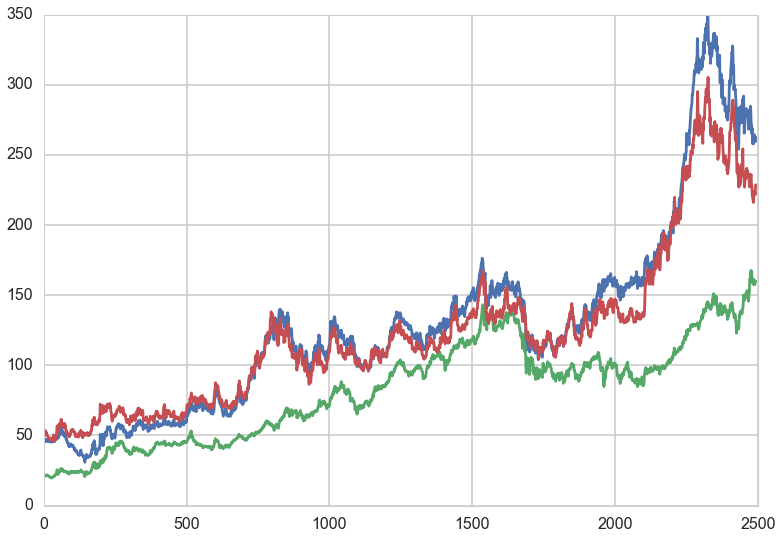

In [9]:
plt.plot(df.index, df["arabica price"])
plt.plot(df.index, df["robusta price"])
plt.plot(df.index, df["futures price"])

In [10]:
#annual Brazil production info
page_prod = requests.get("https://www.quandl.com/api/v3/datasets/BCB/1262.json", params={"start_date": "2001-12-31", "end_date": "2010-12-31", "order": "asc"})

prod_df = pd.DataFrame(page_prod.json()["dataset"]["data"], columns=["year", "prv year prod"])
prod_df["year"] = [int(yr.split("-")[0]) + 1 for yr in prod_df["year"]]

In [11]:
prod_df.head()

year  prv year prod
0  2002        3639138
1  2003        2610524
2  2004        1987074
3  2005        2465710
4  2006        2140169

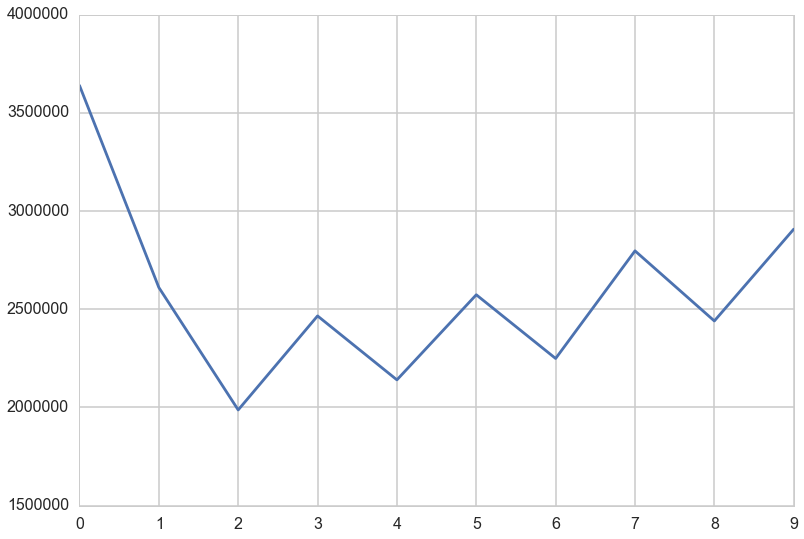

In [12]:
plt.plot(prod_df.index, prod_df["prv year prod"])

resources:
    http://www.investopedia.com/university/commodities/commodities2.asp
    http://www.ico.org/new_historical.asp?section=Statistics
    http://www.wikinvest.com/commodity/Coffee#_note-3

# Weather

Because coffee is a growable commodity, it's production and cost is likely influenced by changes in weather. We hypothesize that better weather in countries with high coffee production will result in lower coffee prices. We can test this hypothesis by first collecting a list of countries and their rate of coffee production. From https://datahero.com/blog/2014/03/28/the-countries-that-drink-the-most-coffee-and-pay-the-highest-prices-for-it/ we can find the ammount of coffee produced by each country every year since 1990 (Thousands of 60kg bags).

In [55]:
prod = pd.DataFrame.from_csv("production.csv")
prod.head(20)

Country Code Season   Type    1990    1991    1992    1993    1994    1995    1996    1997    1998    1999    2000    2001    2002    2003    2004    2005    2006    2007    2008    2009    2010    2011    2012    2013    2014
Country                                                                                                                                                                                                                                              
Angola                      AGO  April  (R/A)      50      79      78      33      77      62      71      64      85      55      50      21      57      38      15      25      35      36      38      13      35      29      33      35      39
Bolivia                     BOL  April    (A)     123     107     123      57     122     152     133     153     150     184     173     118     149     125     170     129     164     133     135     142     130     143     115     128     106
Brazil                      BRA  April  (A/R)  27,286  27,293  34,603  28,167  28,192  18,060  29,197  26,148  36,761  47,578  31,310  31,365  48,480  28,820  39,272  32,944  42,512  36,070  45,992  39,470  48,095  43,484  50,826  49,152  45,342
Burundi                     BDI  April    (A)     487     667     620     393     664     434     401     250     492     351     487     144     454     338     437     103     499     133     412     112     353     204     406     163     252
Ecuador                     ECU  April  (A/R)   1,504   2,124   1,185   2,069   2,376   1,888   1,993   1,191   1,206   1,198     854     793     582     641     780     935   1,035     950     771     813     854     825     828     666     644
Indonesia                   IDN  April  (R/A)   7,441   8,493   5,569   6,743   5,368   4,573   8,221   7,621   7,296   6,557   6,987   6,833   6,731   6,404   7,536   9,159   7,483   7,777   9,612  11,380   9,129   7,288  13,048  11,667   9,350
Madagascar                  MDG  April    (R)     982     933   1,122     442     641     785     849     624     992     427     362     147     445     435     522     599     587     614     728     457     530     585     500     588     518
Malawi                      MWI  April    (A)     105     124     137      62      84      91      49      61      64      59      63      60      42      48      21      24      17      19      21      17      17      26      23      27      16
Papua New Guinea            PNG  April  (A/R)     963     747     900   1,019   1,139   1,002   1,089   1,074   1,352   1,387   1,041   1,063   1,085   1,155     998   1,268     807     968   1,028   1,038     870   1,414     717     828     798
Paraguay                    PRY  April    (A)     131      80      54      70      25      23      26      23      58      20      42      20      26      52      26      45      20      28      21      20      20      21      22      20      20
Peru                        PER  April    (A)     937   1,200   1,762     665   1,179   1,871   1,806   1,930   2,102   2,744   2,676   2,829   3,000   2,686   3,425   2,489   4,319   3,063   3,872   3,286   4,069   5,373   4,453   4,338   2,883
Rwanda                      RWA  April    (A)     535     484     639     444      22     329     293     193     223     307     273     296     320     266     450     337     351     224     369     259     323     251     259     254     258
Timor-Leste                 TLS  April    (A)       0       0       0       0       0       0       0       0       0       0       7      33      37      42      17      24      46      36      48      47      60      50      59      79     104
Zimbabwe                    ZWE  April    (A)     252     201      78      12     106     131     174     130     149     125     109     121     110      92     120      66      45      31      24      21      10       9       7       8      12
Congo, Rep. of              COG   July    (R)       3       3       3       3      

The total changes in production over season and time will be useful in finding correlation with financial pricing. The breakdown of production by country each year will give us the necessary data to weight the average weather by country each season to give us clarity into how weather affects the price of coffee. To do this, we now need to find data on 

It turns out that historical climate data is slightly tricky to aquire. The World Bank offers a great starting point with their free API. By formatting REST requests, we can download monthly rain and temperature data for any country from 1980 to 1999. That leaves 2000-2015 missing, but it give us an accurate starting point.

example: http://climatedataapi.worldbank.org/climateweb/rest/v1/country/mavg/pr/1980/1999/BRA.json

In [ ]:
from time import sleep
import wbpy
from pprint import pprint

c_api = wbpy.ClimateAPI()

# for ccode in ['BRA']: #prod['Country Code']:
locations = sorted(["BRA", "COG", "COD"])
raindf = pd.DataFrame()
tempdf = pd.DataFrame()
for ccode in locations:
    rain_dataset = c_api.get_instrumental(data_type="pr", interval="year", locations=[ccode]).as_dict().itervalues().next()
    raindf[ccode] = pd.Series(rain_dataset)
    
    temp_dataset = c_api.get_instrumental(data_type="tas", interval="year", locations=[ccode]).as_dict().itervalues().next()
    tempdf[ccode] = pd.Series(temp_dataset)

raindf.to_csv('raindf.csv')
tempdf.to_csv('tempdf.csv')